<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/Univariate_encoder_decoder_LSTM_20_7_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# univariate multi-step encoder-decoder lstm for sales prediction

In [1]:
# import libraries
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_excel, DataFrame, read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

**In below cell, if train or test array can not be split into equal sized windows, then padding is performed to make it equal sized.** 

*For example:
If train array is (13,1) and partition = 4, then padding of mean value is done to train in order to make it (16,1) and then splitting is performed*

In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data,partition):
  # split into partition
  train = data[:-partition]
  test = data[-partition:]
  train_original = train
  test_original = test
  # print(type(train))
  # apply padding (if required) in order to split train and test array in equal windows
  if len(train) % partition != 0:
    pad_width = partition - (len(train) % partition)
    train = np.pad(train, (0,pad_width), 'constant', constant_values=(array(train).mean()))

  if len(test) % partition != 0:
    pad_width = partition - (len(test) % partition)
    test = np.pad(test, (0,pad_width), 'constant', constant_values=(array(test).mean()))
    
  # restructure into windows of quarterly data
  train = array(split(train, int(len(train)/partition)))
  test = array(split(test, int(len(test)/partition)))
  return train, test, train_original, test_original

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  rsquare = 0.0
  ss_res = 0.0
  mean_value = actual.mean()
  ss_tot = 0.0
  for i in range(actual.shape[1]):
    #calculate rsquare
    ss_res = ss_res + (actual[:,i][0] - predicted[:, i][0][0])**2
    ss_tot = ss_tot + (actual[:,i][0] - mean_value)**2
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = sqrt(mse)
    # store
    scores.append(int(rmse))

  # calculate R2 score
  rsquare = 1.0 - (ss_res/ss_tot)
  # calculate overall RMSE
  s = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col])**2
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores, rsquare


In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)


In [6]:
# train the model
def build_model(train, n_input, n_out):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_out)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 12
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


In [7]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


In [8]:
# evaluate a single model
def evaluate_model(train, test, n_input, n_out):
  # fit model
  model = build_model(train, n_input, n_out)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get predicted observation and add to history for predicting the next week
    #history.append(test[i, :])
    history.append(yhat_sequence)
  # evaluate predictions days for each week
  predictions = array(predictions)
  rmse, scores, rsquare = evaluate_forecasts(test[:, :, 0], predictions)
  print('RMSE : ' + str(int(rmse)) + ' , Scores : ' + str(scores) + ' , R Sqaured Score : ' + str(rsquare))

  return train, test, predictions, scores


Load Quarterly data

> **In order to make the model more flexible in terms of making predictions, please change 'partition' variable in below cell.**

> **Also, for making changes to input and output vectors
in the LSTM model, make changes to 'n_input' and 'n_out' variables**

> Here, all the 4 quarters are predicted based on previous 4 quarters

> ***Similar Modifications can be done for monthly data as well***

RMSE : 243309 , Scores : [218295, 79929, 425943, 36443] , R Sqaured Score : -1.1283320507400538


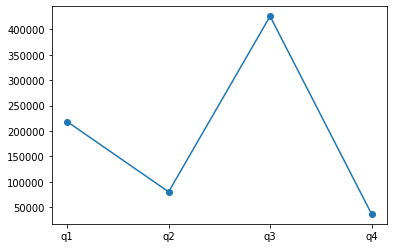

In [9]:
# load the new file
dataset_original = read_csv('/content/Quarterly_Revenue_March_21.csv', header=0, index_col=0)
dataset = DataFrame(dataset_original['Revenue'])
# split into train and test
partition = 4
train, test, train_original, test_original = split_dataset(dataset.values,partition)
# evaluate model and get scores
n_input = 4
n_out = 4
train, test, predictions, scores = evaluate_model(train, test, n_input, n_out)

# plot scores
quarter_list = []
for i in range(partition):
  quarter_list.append('q'+str(i+1))
pyplot.plot(quarter_list, scores, marker='o', label='lstm')
pyplot.show()

# Add Graph for Quarterly prediction

In [10]:
# reset columns
dataset_original.reset_index(level=0, inplace=True)

In [11]:
# convert 'Year' and 'Qaurter' column to string type
dataset_original = dataset_original.astype({"Year": str, "Quarter": str})

In [12]:
# concatenate first two columns
dataset_original['Quarter'] = dataset_original['Year'] + '-' + dataset_original['Quarter']

In [13]:
# set x axis labels
x_axis_label = []
#dictionary to keep track of current year
vis = {}
vis[2017] = 0
vis[2018] = 0
vis[2019] = 0
vis[2020] = 0
vis[2021] = 0
for i in range(len(dataset_original)):
  if vis[int(dataset_original.iloc[i,0])] == 0:
    vis[int(dataset_original.iloc[i,0])] = 1
    x_axis_label.append(str(dataset_original.iloc[i,0]))
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ',
 '2021']

In [14]:
# separate dates for test and training data
dates_train = []
for i in range(len(dataset_original)-partition):
  dates_train.append(dataset_original['Quarter'][i])

dates_train


dates_test = []
for i in range(len(dataset_original)-partition , len(dataset_original)):
  dates_test.append(dataset_original['Quarter'][i])

dates_test

['2020-2', '2020-3', '2020-4', '2021-1']

In [15]:
dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2020-1']

In [16]:
# set prediction interval for each forecast
confidence_upper = []
confidence_lower = []
for i in predictions:
  for j in i:
    x1 = (j[0]+1.96*(array(predictions).std()))
    confidence_upper.append(x1)
    y1 = (j[0]-1.96*(array(predictions).std()))
    confidence_lower.append(max(y1,0))

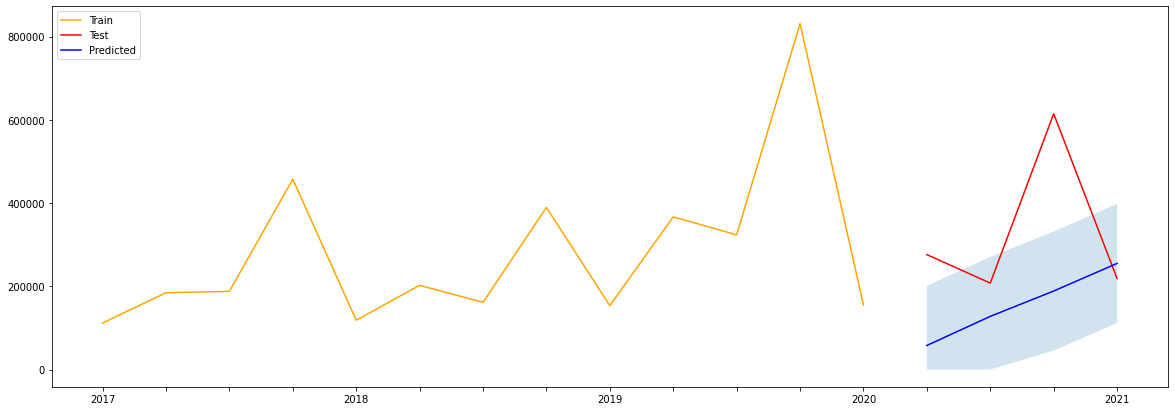

In [17]:
# Plot Graph
plt.figure(figsize=(20,7))
plt.plot(dates_train, train_original, color='orange', label="Train")
plt.plot(dates_test, test_original, color='red', label="Test")
plt.plot(dates_test, predictions.reshape(-1), color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()

Load Monthly data

> Here, all the 12 months are predicted based on previous 12 months

RMSE : 140040 , Scores : [1936, 1386, 183738, 28646, 21080, 66590, 23378, 9338, 436461, 24176, 22048, 60570] , R Sqaured Score : -0.05115146281375771


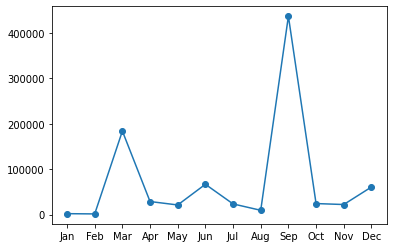

In [18]:
# load the new file
dataset_original = read_csv('/content/Monthly_Revenue_March_21.csv', header=0, index_col=0)
dataset = DataFrame(dataset_original['Revenue'])
# split into train and test
partition = 12
train, test, train_original, test_original = split_dataset(dataset.values,partition)
# evaluate model and get scores
# print(train.shape)
n_input = 12
n_out = 12
train, test, predictions, scores = evaluate_model(train, test, n_input, n_out)

# plot scores
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

pyplot.plot(month_list, scores, marker='o', label='lstm')
pyplot.show()

# Add graph for monthly prediction

In [19]:
# reset columns
dataset_original.reset_index(level=0, inplace=True)

In [20]:
# convert 'Year' and 'Month' column to string type
dataset_original = dataset_original.astype({"Year": str, "Month": str})

In [21]:
# concatenate first two columns
dataset_original['Month'] = dataset_original['Year'] + '-' + dataset_original['Month']

In [22]:
dataset_original.drop(['Year'], axis=1, inplace=True)

In [23]:
# set x axis labels
x_axis_label = []

for i in range(len(dataset_original)):
  if dataset_original.iloc[i,0][-2:] == '-1':
    x_axis_label.append(dataset_original.iloc[i,0][:-2])
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2021',
 ' ',
 ' ']

In [24]:
# separate dates for test and training data
dates_train = []
for i in range(len(dataset_original)-partition):
  dates_train.append(dataset_original['Month'][i])

dates_train


dates_test = []
for i in range(len(dataset_original)-partition , len(dataset_original)):
  dates_test.append(dataset_original['Month'][i])

dates_test

['2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-1',
 '2021-2',
 '2021-3']

In [25]:
dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2017-5',
 '2017-6',
 '2017-7',
 '2017-8',
 '2017-9',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2018-5',
 '2018-6',
 '2018-7',
 '2018-8',
 '2018-9',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2019-5',
 '2019-6',
 '2019-7',
 '2019-8',
 '2019-9',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-1',
 '2020-2',
 '2020-3']

In [26]:
# set prediction interval for each forecast
confidence_upper = []
confidence_lower = []
for i in predictions:
  for j in i:
    x1 = (j[0]+1.96*(array(predictions).std()))
    confidence_upper.append(x1)
    y1 = (j[0]-1.96*(array(predictions).std()))
    confidence_lower.append(max(y1,0))

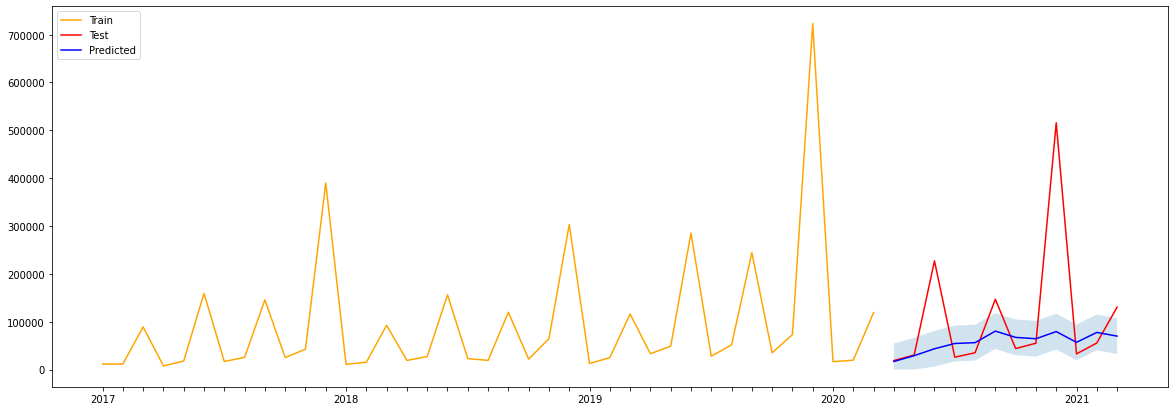

In [27]:
# Plot Graph
plt.figure(figsize=(20,7))
plt.plot(dates_train, train_original, color='orange', label="Train")
plt.plot(dates_test, test_original, color='red', label="Test")
plt.plot(dates_test, predictions.reshape(-1), color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()